In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2
device = torch.device('cpu')

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=k, padding=padding),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.layers(x)


class PipeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extraction backbone
        self.shared_backbone = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 64),
        )

        self.missing_neck = ConvBlock(64, 64)
        self.oxide_neck = ConvBlock(64, 64)
        self.odd_neck = ConvBlock(64, 64)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.head = lambda: nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
        )

        self.missing_head = self.head()
        self.oxide_head = self.head()
        self.odd_head = self.head()

    def forward(self, x):
        features = self.shared_backbone(x)

        missing = self.missing_neck(features)
        missing = self.avg_pool(missing).view(x.shape[0], -1)
        missing = self.missing_head(missing).view(-1, 4, 10)

        oxide = self.oxide_neck(features)
        oxide = self.avg_pool(oxide).view(x.shape[0], -1)
        oxide = self.oxide_head(oxide).view(-1, 4, 10)

        odd = self.odd_neck(features)
        odd = self.avg_pool(odd).view(x.shape[0], -1)
        odd = self.odd_head(odd).view(-1, 4, 10)

        return {
            "missing": missing,
            "oxide": oxide,
            "odd": odd,
        }


model = PipeNetwork().to(device)
model.load_state_dict(torch.load(f'./checkpoints/pipe_detector.pth'))
model.to(device)

PipeNetwork(
  (shared_backbone): Sequential(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_s

missing: tensor([[[1., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1., 0., 1., 1., 0., 1.]]], grad_fn=<RoundBackward0>)
oxide: tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], grad_fn=<RoundBackward0>)
odd: 0.3628769814968109


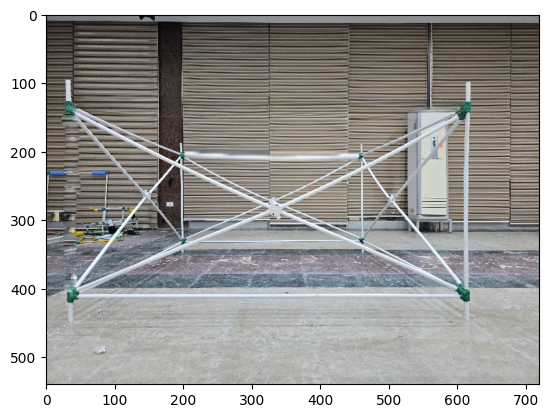

In [20]:
model.eval()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

img = Image.open('./data/test/4.jpeg').convert("RGB")
img_t = transform(img).unsqueeze(0)

result = model(img_t)

print(f'missing: {torch.sigmoid(result['missing']).round()}')
print(f'oxide: {torch.sigmoid(result['oxide']).round()}')
print(f'odd: {torch.sigmoid(result['odd']).max()}')
plt.imshow(img)